In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import requests
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [59]:
pd.set_option('display.max_colwidth', -1)
r = requests.get("https://api.opendota.com/api/leagues")
print(r.json()[:10])
leagues = pd.DataFrame(r.json())
print(leagues)
leagues.sort_values("leagueid")

proleagues = leagues[leagues["name"].str.contains("DPC")]
NADPC = proleagues[proleagues["name"].str.contains("(NA)")]
print(NADPC[["leagueid","name"]])
SADPC = proleagues[proleagues["name"].str.contains("(SA)")]
print(SADPC[["leagueid","name"]])
SEADPC = proleagues[proleagues["name"].str.contains("(SEA)")]
print(SEADPC[["leagueid","name"]])
CNDPC = proleagues[proleagues["name"].str.contains("(CN)")]
print(CNDPC[["leagueid","name"]])
WEUDPC = proleagues[proleagues["name"].str.contains("(WEU)") | proleagues["name"].str.contains("Western Europe")]
print(WEUDPC[["leagueid","name"]])
EEUDPC = proleagues[proleagues["name"].str.contains("(EEU)") | proleagues["name"].str.contains("(CIS)") | proleagues["name"].str.contains("Eastern Europe")]
print(EEUDPC[["leagueid","name"]])


[{'leagueid': 11894, 'ticket': None, 'banner': None, 'tier': 'premium', 'name': 'adsf'}, {'leagueid': 4668, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'ClanWar SnooKeR Cup #1'}, {'leagueid': 1535, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'Possible Heroes Cup Season 1'}, {'leagueid': 3894, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'Dragon League Season 1'}, {'leagueid': 10484, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'testcop'}, {'leagueid': 2031, 'ticket': 'econ/leagues/subscriptions_impact_gaming_s1', 'banner': 'econ/leagues/subscriptions_impact_gaming_s1_ingame', 'tier': 'amateur', 'name': 'Impact Gaming Season 1'}, {'leagueid': 1994, 'ticket': 'econ/leagues/subscriptions_zozo', 'banner': 'econ/leagues/subscriptions_zozo_ingame', 'tier': 'amateur', 'name': 'Zo-Zo Cup #1'}, {'leagueid': 4608, 'ticket': 'econ/leagues/subscriptions_belnation_dota_league_9_', 'banner': 'econ/leagues/subscriptions_belnation_dota_leag

In [4]:
leagueids = {"NA Season 1":12735,"NA Season 2 Upper":13119,"NA Season 2 Lower":13120,
            "SA Season 1":12727,"SA Season 2 Upper":13109,"SA Season 2 Lower":13110,
            "SEA Season 1":12705,"SEA Season 2 Upper":13108,"SEA Season 2 Lower":13107,
            "CN Season 1":12723,"CN Season 2 Upper":13112,"CN Season 2 Lower":13113,
            "WEU Season 1":12720,"WEU Season 2 Upper":13114,"WEU Season 2 Lower":13115,
            "EEU Season 1":12718,"EEU Season 2 Upper":13116,"EEU Season 2 Lower":13117}

In [5]:
#SQL query for OpenDota explorer
"""
SELECT
matches.match_id,
matches.picks_bans,
matches.radiant_team_id,
matches.dire_team_id,
leagues.name leaguename,
team1.name AS radiant_team,
team2.name AS dire_team
FROM matches
JOIN leagues using(leagueid)
JOIN teams team1 ON matches.radiant_team_id = team1.team_id
JOIN teams team2 ON matches.dire_team_id = team2.team_id
WHERE leagueid = #####
"""

"https://www.opendota.com/explorer?sql=SELECT%0Amatches.match_id%2C%0Amatches.picks_bans%2C%0Amatches.radiant_team_id%2C%0Amatches.dire_team_id%2C%0Aleagues.name%20leaguename%2C%0Ateam1.name%20AS%20radiant_team%2C%0Ateam2.name%20AS%20dire_team%0AFROM%20matches%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20teams%20team1%20ON%20matches.radiant_team_id%20%3D%20team1.team_id%0AJOIN%20teams%20team2%20ON%20matches.dire_team_id%20%3D%20team2.team_id%0AWHERE%20leagueid%20%3D%2012723&format="

'https://www.opendota.com/explorer?sql=SELECT%0Amatches.match_id%2C%0Amatches.picks_bans%2C%0Amatches.radiant_team_id%2C%0Amatches.dire_team_id%2C%0Aleagues.name%20leaguename%2C%0Ateam1.name%20AS%20radiant_team%2C%0Ateam2.name%20AS%20dire_team%0AFROM%20matches%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20teams%20team1%20ON%20matches.radiant_team_id%20%3D%20team1.team_id%0AJOIN%20teams%20team2%20ON%20matches.dire_team_id%20%3D%20team2.team_id%0AWHERE%20leagueid%20%3D%2012723&format='

In [6]:
#Encoding each pick or ban as a discrete column would be too sparse for the size of our dataset and would not represent 
#the relationship between each pick and ban, ie. picking a hero 1st and 2nd represents a more closely aligned preference
#than picking a hero 1st and 5th, or picking it 3rd and not picking it at all.
#So instead we will assign numerical values to each option, pick or ban to give each hero a value in each match for each team.

#first iteration
#first 4 bans = 2
#first 4 picks = 2
#next 6 bans = 1.5
#next 4 picks = 1.5
#last 4 bans = 1
#last 2 picks = 1

#we can approximate this with the function 2 - x/23 where x is the pick/ban order.

In [7]:
import requests

#first we get the hero ids:
r = requests.get("https://api.opendota.com/api/heroes")

heroes = {}

for hero in r.json():
    i = hero["id"]
    name = hero["localized_name"]
    heroes[i] = name
    
print(heroes)

{1: 'Anti-Mage', 2: 'Axe', 3: 'Bane', 4: 'Bloodseeker', 5: 'Crystal Maiden', 6: 'Drow Ranger', 7: 'Earthshaker', 8: 'Juggernaut', 9: 'Mirana', 10: 'Morphling', 11: 'Shadow Fiend', 12: 'Phantom Lancer', 13: 'Puck', 14: 'Pudge', 15: 'Razor', 16: 'Sand King', 17: 'Storm Spirit', 18: 'Sven', 19: 'Tiny', 20: 'Vengeful Spirit', 21: 'Windranger', 22: 'Zeus', 23: 'Kunkka', 25: 'Lina', 26: 'Lion', 27: 'Shadow Shaman', 28: 'Slardar', 29: 'Tidehunter', 30: 'Witch Doctor', 31: 'Lich', 32: 'Riki', 33: 'Enigma', 34: 'Tinker', 35: 'Sniper', 36: 'Necrophos', 37: 'Warlock', 38: 'Beastmaster', 39: 'Queen of Pain', 40: 'Venomancer', 41: 'Faceless Void', 42: 'Wraith King', 43: 'Death Prophet', 44: 'Phantom Assassin', 45: 'Pugna', 46: 'Templar Assassin', 47: 'Viper', 48: 'Luna', 49: 'Dragon Knight', 50: 'Dazzle', 51: 'Clockwerk', 52: 'Leshrac', 53: "Nature's Prophet", 54: 'Lifestealer', 55: 'Dark Seer', 56: 'Clinkz', 57: 'Omniknight', 58: 'Enchantress', 59: 'Huskar', 60: 'Night Stalker', 61: 'Broodmother',

In [90]:
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

directory = "D:\\Stratz\\"

load_dict = {}

regions = ["NA","SA","SEA","CN","EEU","WEU"]
seasons = ["Season 1","Season 2 Upper","Season 2 Lower"]
for region in regions:
    for season in seasons:
        leagueid = leagueids[region + " " + season]
        r = requests.get("https://api.opendota.com/api/explorer?sql=SELECT%0Amatches.match_id%2C%0Amatches.picks_bans%2C%0Amatches.radiant_team_id%2C%0Amatches.dire_team_id%2C%0Aleagues.name%20leaguename%2C%0Ateam1.name%20AS%20radiant_team%2C%0Ateam2.name%20AS%20dire_team%0AFROM%20matches%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20teams%20team1%20ON%20matches.radiant_team_id%20%3D%20team1.team_id%0AJOIN%20teams%20team2%20ON%20matches.dire_team_id%20%3D%20team2.team_id%0AWHERE%20leagueid%20%3D%20{0}&format=".format(leagueid))
        for match in r.json()["rows"]:
            pickbans = match["picks_bans"]
            if not pickbans:
                #this match was probably remade or for some other reason the draft phase wasn't recorded, for now we ignore.
                continue
            radiantteam = match["radiant_team"]
            direteam = match["dire_team"]
            radianttup = (region,radiantteam)
            diretup = (region,direteam)
            if radianttup not in load_dict:
                load_dict[radianttup] = dict(zip(heroes.keys(), [0]*len(heroes.keys())))
            if diretup not in load_dict:
                load_dict[diretup] = dict(zip(heroes.keys(), [0]*len(heroes.keys())))         
            for pickban in pickbans:
                heroid = pickban["hero_id"]
                team = pickban["team"]
                order = pickban["order"]
                score = 10 - order/23
                if team:
                    load_dict[diretup][heroid] += score
                else:
                    load_dict[radianttup][heroid] += score
        time.sleep(10)
            
print(load_dict)


{('NA', 'Evil Geniuses'): {1: 0, 2: 9.08695652173913, 3: 9.391304347826086, 4: 19.043478260869563, 5: 37.65217391304348, 6: 18.82608695652174, 7: 38.21739130434783, 8: 84.47826086956522, 9: 38.78260869565217, 10: 37.78260869565217, 11: 0, 12: 37.08695652173913, 13: 136.43478260869566, 14: 9.347826086956522, 15: 27.782608695652176, 16: 9.173913043478262, 17: 103.43478260869564, 18: 9.391304347826086, 19: 56.86956521739131, 20: 0, 21: 18.565217391304348, 22: 0, 23: 27.956521739130437, 25: 27.82608695652174, 26: 38.69565217391305, 27: 77.30434782608695, 28: 37.30434782608695, 29: 64.82608695652173, 30: 105.95652173913044, 31: 0, 32: 27.782608695652172, 33: 46.95652173913043, 34: 0, 35: 0, 36: 18.869565217391305, 37: 39.0, 38: 77.73913043478261, 39: 9.0, 40: 55.608695652173914, 41: 9.043478260869565, 42: 37.34782608695652, 43: 94.43478260869566, 44: 18.26086956521739, 45: 0, 46: 18.52173913043478, 47: 133.13043478260875, 48: 47.26086956521739, 49: 9.652173913043478, 50: 0, 51: 0, 52: 28.04

In [91]:
df = pd.DataFrame.from_dict(load_dict,orient='index',columns=heroes.keys())
df.index.names = ['Region','Team']
print(df)

                               1          2          3          4    \
Region Team                                                           
NA     Evil Geniuses      0.000000   9.086957   9.391304  19.043478   
       Quincy Crew        0.000000   9.347826   0.000000  18.695652   
       Arkosh Gaming     18.956522  18.478261  19.913043   9.000000   
       Simply TOOBASED   18.173913  18.391304   0.000000  18.434783   
       Undying            9.217391  18.608696   0.000000   9.565217   
...                            ...        ...        ...        ...   
WEU    burjui            18.695652   9.521739   0.000000   0.000000   
       Level UP           9.521739  18.130435   0.000000   9.608696   
       Team Bald Reborn   0.000000   9.000000   9.086957  47.826087   
       Into The Breach   18.956522  65.826087   0.000000   0.000000   
       Ghost Frogs       28.130435  37.782609   9.391304  37.956522   

                               5          6          7           8    \
Regi

In [92]:
print(df.xs("WEU", level="Region").sum(axis=1))
df = df.div(df.sum(axis=1), axis=0)
print(df.xs("NA", level="Region").sum(axis=1))

Team
Hippomaniacs         3297.782609
Meta4Pro             1368.347826
Brame                4217.565217
Spider Pigzs         1936.086957
Into the Breach      2280.130435
No Bounty Hunter     3876.434783
mudgolems             912.347826
OG                   4787.086957
Nigma                4102.869565
ViKin.gg             4103.956522
high coast           1254.521739
Tundra Esports       4106.608696
Alliance             4332.086957
Team Liquid          4558.826087
Team Secret          3990.000000
Hellbear Smashers    4104.260870
Chicken Fighters     2052.608696
burjui               1253.478261
Level UP             1823.739130
Team Bald Reborn     1710.391304
Into The Breach      1367.478261
Ghost Frogs          1938.391304
dtype: float64
Team
Evil Geniuses          1.0
Quincy Crew            1.0
Arkosh Gaming          1.0
Simply TOOBASED        1.0
Undying                1.0
A-Team                 1.0
sadboys                1.0
Black N Yellow         1.0
5ManMidas              1.0
Electr

In [93]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(df)

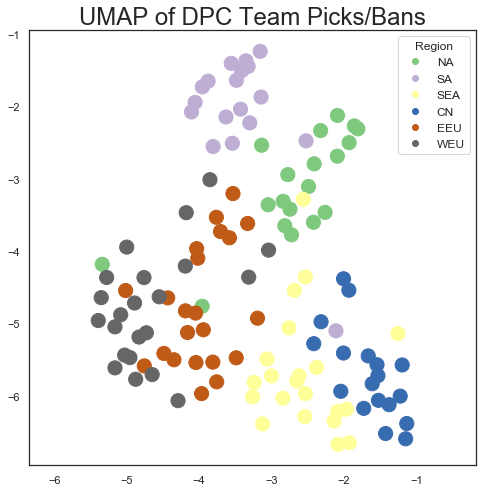

In [98]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

labelit = False

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=[regions.index(x[0]) for x in df.index],cmap="Accent",s=200)
legend = plt.legend(scatter.legend_elements()[0],regions,loc="upper right",title="Region",fontsize=12)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of DPC Team Picks/Bans', fontsize=24)
if labelit:
    for team,point in zip(df.index,embedding):
        label = team[1]
        plt.annotate(label, # this is the text
                     point, # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center